# Homework: Logistic Regression Classification with SciKit-Learn

This homework demonstrates how SciKit-Learn can be used to build logistic regression models, improve models with feature scaling, and measure performance. You'll predict energy load usage and build a simple handwriten digit classifier.

***Summary***
1. [Understanding the Data](#understand-the-data)
2. [Classification with Feature Scaling](#feature-scaling)
3. [Precision, Recall, and Confusion Matrix](#confusion-matrices)

***
<a id='understand-the-data'></a>
## 1. Understanding the Data

The dataset was created by Angeliki Xifara ( Civil/Structural Engineer) and was processed by Athanasios Tsanas, Oxford Centre for Industrial and Applied Mathematics, University of Oxford, UK). The Data file should be next to your notebook file called : `Energy.csv`

In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path='./Energy.csv'
data = pd.read_csv(file_path)

# Check top 5 rows of the data
data.head(5)

,X1,X2,X3,X4,X5,X6,X7,X8,Y1
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


The dataset contains eight attributes of a building (or features, denoted by `X1` ... `X8`) and response being the heating load on the building, `Y1`. 

* `X1` relative Compactness 
* `X2`	Surface Area 
* `X3`	Wall Area 
*  `X4`	Roof Area 
*  `X5`	Overall Height 
* `X6`	Orientation 
*  `X7`	Glazing Area 
*  `X8`	Glazing Area Distribution 
*  `Y1`	Heating Load 

 **Q1 a) Describe the distribution range of the data features. Create a dataframe where the columns are data features and response variables and the rows indices are count, mean, min, and max (in *this exact* order). Store the output of the above operation result in a new variable called `distribution`.*** 
 
 Your plotted image should look like this:<br>
<center><img src='assets/q1a_expected.png' width = 500>
    
*Hint:* Use [`pandas.DataFrame.describe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)

In [3]:
distribution = data.describe()
distribution.drop(['std', '25%', '50%', '75%'], inplace = True)
distribution

,X1,X2,X3,X4,X5,X6,X7,X8,Y1
count,768.000000,768.000000,768.0,768.000000,768.00,768.0,768.000000,768.0000,768.000000
mean,0.764167,671.708333,318.5,176.604167,5.25,3.5,0.234375,2.8125,22.307201
min,0.620000,514.500000,245.0,110.250000,3.50,2.0,0.000000,0.0000,6.010000
max,0.980000,808.500000,416.5,220.500000,7.00,5.0,0.400000,5.0000,43.100000


__Q1 b) Check if there are any NaN/null values. Store the anaswer as boolean True or False in the variable `any_nulls`.__


In [4]:
any_nulls = pd.isna(data).all().all()
any_nulls

False

**Q1 c) Separate the data into features and output labels. Take the columns labelled `X1` to `X8` and store them in a new variable called `X`. Store the column `Y1` into a new variable called `Y`.**

In [5]:
X = data.loc[:, 'X1':'X8']
Y = data['Y1']
print('X:')
display(X.head())
print('Y:')
display(Y.head())

X:


,X1,X2,X3,X4,X5,X6,X7,X8
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0


Y:


0    15.55
1    15.55
2    15.55
3    15.55
4    20.84
Name: Y1, dtype: float64

**Q1 d) [OPTIONAL] Plot feature distributions. This step should give you clues about data sufficiency. (This question is not graded, it's intended for your reference only.)***

Your plotted image should look like this: <br>
<center><img src='assets/q1d_expected.PNG' width = 400>

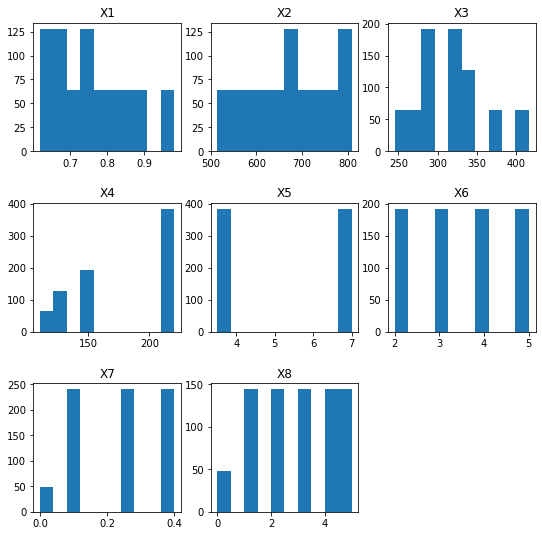

In [6]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (9, 9)
f, ax = plt.subplots(nrows=3,ncols=3)

data_cols = X.columns

k = 0
for i in range(3):
    for j in range(3):
        if k < 8:
            ax[i,j].hist(X[data_cols[k]])
            ax[i,j].set_title(data_cols[k])
            k += 1
        else:
            ax[i,j].axis('off')
        
plt.subplots_adjust(hspace=0.4)        
plt.show()  

<a id='feature-scaling'></a>
## 2. Classification with Feature Scaling
- Labels are discrete values in classification tasks.
- Here the model is trained to classify each instance into a set of predefined  discrete classes.
- On inputting a feature vector into the model, the trained model is able to predict a  class of that instance. You can also output the probabilities of an instance belnging to a class.  

**Q2 a):  Bucket the response variable `Y1` (`Heating Load`) from the original dataset into 3 classes based on the ranges below. Save this new column in a `pd.Series` named `Y_class`. Then use `pd.Series.value_counts()` to see how many values are in each class.**

- `Low` : (0, 14]  
-  `Medium` : (14, 28]
-  `High` :  (28, Inf]

This converts the given dataset into a classification problem where the classes to predict are the heating load types (`Low`, `Medium`, `High`). We will use this new datset with the transformed heating load column to create a  logistic regression classification model. 

*HINT:* Use [`pandas.cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html)

In [7]:
Y_class = pd.cut(data['Y1'], bins = [0, 14, 28, np.inf], labels = ['Low', 'Medium', 'High'])
Y_class.value_counts()

High      283
Medium    267
Low       218
Name: Y1, dtype: int64

**Q2 b) Split the dataset into training and test.**
- Use test-train split ratio of 0.8 : 0.2 (`test_size = 0.2`) and `random_state = 100`
- When initialize your logistic regression model set `max_iter = 1e4`

In [8]:
from sklearn.model_selection import train_test_split

random_state=100 # Use this random state in your model
test_size = 0.2

x_train, x_test, y_train, y_test = train_test_split(X, Y_class, test_size = 0.2, random_state = 100)
print ('Number of samples in training data:', len(x_train))
print ('Number of samples in validation data:', len(x_test))

Number of samples in training data: 614
Number of samples in validation data: 154


**Q2 c) Fit two logistic regression models to the training data. One model should use Softmax Regression (multinomial) and the other should use the One-vs-Rest procedure.**

- For both models, initialize your model with `max_iter = 1e4`
- You can specify the type of multiclass logistic regression model by the `multi_class` parameter in `linear_model.LogisticRegression(...)`
    - One-vs-Rest (One-vs-All): `multi_class = 'ovr'`
    - Softmax Regression (Multinomial): `multi_class = 'multinomial'`

In [9]:
from sklearn import linear_model

# Name our regression objects
logreg_model_ovr = linear_model.LogisticRegression(max_iter=1e4, multi_class = 'ovr')
logreg_model_mult = linear_model.LogisticRegression(max_iter=1e4, multi_class = 'multinomial')

# Fit the training data to our models
logreg_model_ovr.fit(x_train, y_train)
logreg_model_mult.fit(x_train, y_train)

LogisticRegression(max_iter=10000.0, multi_class='multinomial')

**Q2 d) Calculate the training and test accuracies for both the One-vs-Rest and Softmax Regression Models. (You should report a total of 4 accuracy measurements)**

In [10]:
def print_train_test_accuracy(model, x_train, x_test, y_train, y_test):
    training_accuracy = model.score(x_train,y_train)
    test_accuracy = model.score(x_test,y_test)
    print ('\t Training Accuracy:', training_accuracy)
    print ('\t Testing Accuracy:', test_accuracy)

# Calculate training and test accuracies for OvR
print('One-vs-Rest (One-vs-All):')
print_train_test_accuracy(logreg_model_ovr, x_train, x_test, y_train, y_test)

# Calculate training and test accuracies for multinomial regression
print('Softmax Regression (Multinomial):')
print_train_test_accuracy(logreg_model_mult, x_train, x_test, y_train, y_test)

One-vs-Rest (One-vs-All):
	 Training Accuracy: 0.8110749185667753
	 Testing Accuracy: 0.7727272727272727
Softmax Regression (Multinomial):
	 Training Accuracy: 0.7964169381107492
	 Testing Accuracy: 0.7857142857142857


__Q2 e): Perform unity based normalization on the above dataset and train the model again. You will compare the performance of the models trained on scaled data with the training and test accuracies of your original model.__  

One of the preprocessing steps in Data science is Feature Scaling i.e getting all our data on the same scale by setting same Min-Max of feature values. 
This makes training less sensitive to the scale of features . 
Scaling is important in algorithms that use distance based classification, SVM or K means or those that involve gradient descent optimization. If we  scale features in the range [0,1] it is called unity based normalization or Min-Max scaling.

Refer: http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler  
More at: https://en.wikipedia.org/wiki/Feature_scaling

In this question, you will be comparing the performance of the Min-Max Scaler to the Standard Normal Scaler. You should use the same training and test split from **Q2 b**. Follow the guidelines below:

1. You should create two transformed `X` datasets. Scale (transform) `X` with the Min-Max Scaler. Save this dataset as `X_minmax_scaler`
2. Scale `X` by the Standard Normal Scaler and save this dataset as `X_std_scaled`
3. Split `X_minmax_scaled` and `X_std_scaled` using the same parameters: `random_state = 100` and `test_size = 0.2`
4. Initialize, train and fit separate models for each scaler. Use `max_iter=1e4` and `multi_class = multinomial`
5. Report the both the Training and Test Accuracy for each of the two scalers.

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Create scalers
std_scaled = StandardScaler().fit(X)
minmax_scaled = MinMaxScaler().fit(X)

# Scale (transform) datasets
X_std_scaled = std_scaled.transform(X)
X_minmax_scaled = minmax_scaled.transform(X)

# Split data
x1_train, x1_test, y1_train, y1_test = train_test_split(X_std_scaled, Y_class, test_size = 0.2, random_state = 100)
x2_train, x2_test, y2_train, y2_test = train_test_split(X_minmax_scaled, Y_class, test_size = 0.2, random_state = 100)

# Train
logreg_model_std = linear_model.LogisticRegression(max_iter=1e4, multi_class = 'multinomial')
logreg_model_minmax = linear_model.LogisticRegression(max_iter=1e4, multi_class = 'multinomial')

# Fit the training data to our models
logreg_model_std.fit(x1_train, y1_train)
logreg_model_minmax.fit(x2_train, y2_train)

# Calculate training and test accuracies for OvR
print('Standard Scaler:')
print_train_test_accuracy(logreg_model_std, x1_train, x1_test, y1_train, y1_test)

print('Min-Max Scaler:')
print_train_test_accuracy(logreg_model_minmax, x2_train, x2_test, y2_train, y2_test)

Standard Scaler:
	 Training Accuracy: 0.8713355048859935
	 Testing Accuracy: 0.922077922077922
Min-Max Scaler:
	 Training Accuracy: 0.8599348534201955
	 Testing Accuracy: 0.9090909090909091


<a id='confusion-matrices'></a>
## 3. Precision, Recall, and Confusion Matrix

In this section, we will be training a logistic regression model to classify handwritten digits. SciKit learn has a collection of ready-to-use datasets which we will use here.
Parts of this questions were drawn from: https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()
print('Images in this dataset: %i' % len(digits.images))

Images in this dataset: 1797


For this question, we'll access the following attributes of `digits`:
- `digits.images`: All the images stored as 8x8 arrays.
- `digits.data`: All the images stored as 1x64 arrays. (The images have been "flattened" so we can train our model.)
- `digits.target`: The label for each of the images. (The first label corresponds to the first image in `digits.images` and `digits.data` and the second matches the second image and so on...)
- `target_names`: List of unique labels (i.e. 0, 1, 2 ... 9)

Each image is stored as an 8x8 array. When building our model we will use the flattened 1x64 array representation, but for now let's look at an 8x8 array. The first image in the data set is stored as:

In [13]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

The 0's correspond to white squares and the higher numbers correspond to darker squares. The first image looks like this:

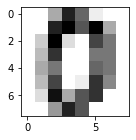

In [14]:
plt.figure(figsize = (2,2))
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest');

Let's take a look at the first 10 handwritten digits in the dataset.

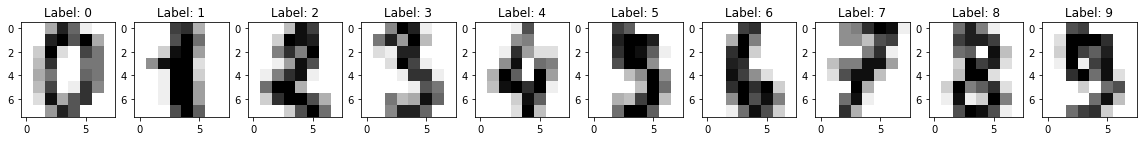

In [15]:
fig, axes = plt.subplots(1, 10,figsize=(20,20))
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes.reshape(10,), images_and_labels[:10]):
    #ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Label: %i' % label)

**Q3 a):  Create a histogram to show how many images exist for each label in the dataset. Does there appear to be an even distribution of labels?**

*HINT:* Use `digits.target` 

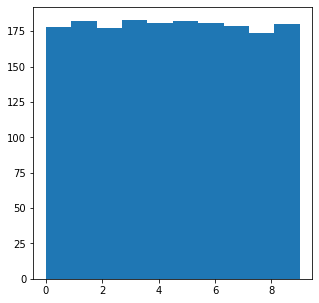

In [16]:
plt.figure(figsize=(5,5))
plt.hist(digits.target);

**Q3 b)  Train a logistic regression model to classify the images. Use the following parameters.**
1. Split the data into training and test sets. Use `random_state=100` and `test_size=0.90`. (Note: Our model we be fairly good, so we can use a small training set.)
2. Intialize and fit a logistic regression model using `max_iter=1e4` and `multi_class = 'multinomial'`
3. Report the training and test accuracies.


In [17]:
## Split the train and testing data
random_state=100 # don't change these lines
test_size=0.90 # don't change these lines

X = digits.data
Y = digits.target

# Split the data
x3_train, x3_test, y3_train, y3_test = train_test_split(X, Y, test_size = 0.90, random_state = 100)

# Intialize and fit our logistic regression model
logreg_image_classifier = linear_model.LogisticRegression(max_iter=1e4, multi_class = 'multinomial')
logreg_image_classifier.fit(x3_train, y3_train)

training_accuracy= logreg_image_classifier.score(x3_train, y3_train)
print ('Training Accuracy:', training_accuracy)

training_accuracy= logreg_image_classifier.score(x3_test, y3_test)
print ('Test Accuracy:', training_accuracy)

Training Accuracy: 1.0
Test Accuracy: 0.9128553770086527


**Q3 c)  Create a confusion matrix for the logistic regression model you created in the previous question. From visually inspecting the confusion matrix, which digit does the model appear to have the hardest time classifying (i.e. digit with the least correctly labeled instances)?**

Confusion matrix:
[[157   0   0   0   1   0   2   0   0   0]
 [  0 150   4   5   0   0   7   0   1   0]
 [  1   5 141  13   0   0   0   1   1   0]
 [  0   0   0 161   0   0   0   1   3   1]
 [  0  13   0   0 149   0   2   2   0   0]
 [  0   1   0   3   1 155   2   2   0   2]
 [  0   1   0   0   0   0 155   0   1   0]
 [  0   1   1   1   2   0   0 148   2   2]
 [  0  14   2   4   2   2   3   1 124   2]
 [  2   3   0   9   0   4   0   2   6 137]]


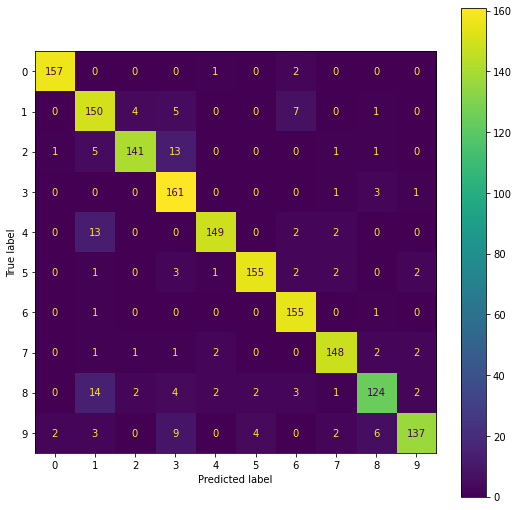

In [18]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

disp = metrics.plot_confusion_matrix(logreg_image_classifier, x3_test, y3_test)
print("Confusion matrix:\n%s" % disp.confusion_matrix)

*The model has a hard time classifiying 8.*

**Q3 d) What is the proportion of images with a *predicted* label of `1` that have the correct label? Is this precision or recall?**

*HINT*: Use [`sklearn.metrics.classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [19]:
# Predict the image labels on the test set
predicted = logreg_image_classifier.predict(x3_test)

print("Classification report for classifier %s:\n%s\n" % (logreg_image_classifier, metrics.classification_report(y3_test, predicted)))

Classification report for classifier LogisticRegression(max_iter=10000.0, multi_class='multinomial'):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       160
           1       0.80      0.90      0.85       167
           2       0.95      0.87      0.91       162
           3       0.82      0.97      0.89       166
           4       0.96      0.90      0.93       166
           5       0.96      0.93      0.95       166
           6       0.91      0.99      0.95       157
           7       0.94      0.94      0.94       157
           8       0.90      0.81      0.85       154
           9       0.95      0.84      0.89       163

    accuracy                           0.91      1618
   macro avg       0.92      0.91      0.91      1618
weighted avg       0.92      0.91      0.91      1618




*Precision. Class 1 has a precision = 0.80*

**Q3 e) What is the proportion of images with an *actual* label of `8` that have the correct label? Is this precision or recall?**

*Recall. Class 8 has a recall = 0.81*